<a href="https://colab.research.google.com/github/beatriceyapsm/Text-Classification-and-Time-Information-Extraction/blob/main/2A%20SemEval10%20Binary%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group 9C SGUS NUS Capstone Project 2022 
### Improve Demand Forecasting through Natural Language Processing for Panasonic

The objective of the project is to develop a technology to detect cause-effect relationship from news corpora using Lexicon based relation identification

Methodology: 
1.   Data Preparation
2.   Model Training
3. Model Optimisation
4. Model Evaluation


## Step 1: Data preparation

#### We will be using SEMEVAL2010 Data set as suggested by Panasonic for this exercise https://www.kaggle.com/datasets/drtoshi/semeval2010-task-8-dataset

The data set comes with predefined labels e1 and e2 in the following categories:
1. Cause - Effect
2. Compent - Whole
3. Member - Collection
4. Content - Container
5. Entity - Destination
6. Message - Topic
7. Prouct - Producer
8. Instrument - Agency
9. Entity - Origin
10. Other

####Import Python Libraries and Define Global Variables

In [213]:

#Import Pandas and Numpy Python Libraries
import pandas as pd        #data analysis and manipulation library for Python
import numpy as np         #mathematical operations over arrays

#Global variables
train_data = []            #sentence for training with labels 
train_target = []          #labels for training data
test_data = []             #sentence for testing with labels  
test_target = []           #labels for testing data

#### Create data frames

In [214]:
#Import files into a dataframe
def import_text(file_txt):
    
    colnames=['ID', 'Text'] 
    
    df = pd.read_csv(file_txt
                       ,skip_blank_lines=True   #input files have emplty lines
                       ,header=None             #no haeders
                       ,sep='\t'                #tab delimited
                       ,engine='python'         #engine
                       ,quotechar='^'           #if there are doublequotes in the text
                       ,comment='Comment:'      #this is for human reader, we don't need
                       ,names=colnames          #preset columns we need
                      )
    print("Number of rows: ", len(df.index))

    return df

In [215]:
#clean ""
def clean_doublequotes(df):
    return df.replace('"', '', regex=True)

In [216]:
#BEATRICE replace all other classifications with "Other"//so we do not lose these samples
def clean_class(df):
    
    return df.replace(regex=['Product-Producer','Entity-Origin','Instrument-Agency','Component-Whole','Content-Container','Entity-Destination','Member-Collection','Message-Topic'], value='Other')

In [217]:
#clean tags e.g. (e2,e1) - to check why?
def clean_tags(df_column,braket_type):
    
    if braket_type == 'angle':
        pattern = r'<.*?>'
    elif braket_type == 'round':
        pattern = r'(\(.*?\))'
    else:
        raise Exception("angle or round")
    
    return df_column.str.replace(pattern, '', regex=True)

In [218]:
#create tuple of keys
keys = ('Other','Cause-Effect')
#keys = ('Other','Cause-Effect','Product-Producer','Entity-Origin','Instrument-Agency','Component-Whole','Content-Container','Entity-Destination','Member-Collection','Message-Topic')
#for i in range(len(keys)): print(i, keys[i])

In [219]:
def prepare_file(file_name,use):
    
    #Import training file into a dataframe
    df = import_text(file_name)

    #clean ""
    df = clean_doublequotes(df)

    #BEATRICE make binary
    df = clean_class(df)

    # combine rows 1&2
    df['Clasification'] = df['ID'].shift(-1)

    #remove leftover rows
    df = df[df.Text.notna()]

    #clean tags e.g. <e2> - better option would be to keep them and use for more precise prediction
    df.Text = clean_tags(df.Text,braket_type='angle')

    #clean tags e.g. (e2,e1) - better option would be to keep them and use for more precise prediction
    df.Clasification = clean_tags(df.Clasification,braket_type='round')

    #Map Keys to numbers
    df['Clasification_ID'] = df.Clasification.map(lambda x: keys.index(x))

    #to use in thes same file
    if use == 'train':
        global train_data
        train_data = df.Text
        
        global train_target
        train_target = df.Clasification_ID
    elif use == 'test':
        global test_data
        test_data = df.Text
        
        global test_target
        test_target = df.Clasification_ID

    #check
    print('Output rows:', len(df.index))
  
    return df

#### Prepare Training file

In [220]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [221]:
%cd /content/drive/MyDrive/Github/Group-9C-Capstone

/content/drive/MyDrive/Github/Group-9C-Capstone


In [222]:
#prepare file
df_train = prepare_file('semeval2010task8_train.txt','train')

df_train.head(5)

Number of rows:  16000
Output rows: 8000


,ID,Text,Clasification,Clasification_ID
0,1,The system as described above has its greatest...,Other,0
2,2,The child was carefully wrapped and bound into...,Other,0
4,3,The author of a keygen uses a disassembler to ...,Other,0
6,4,A misty ridge uprises from the surge.,Other,0
8,5,The student association is the voice of the un...,Other,0


In [223]:
df_test = prepare_file('semeval2010task8_test.txt','test')

df_test.head(5)

Number of rows:  5434
Output rows: 2717


,ID,Text,Clasification,Clasification_ID
0,8001,The most common audits were about waste and re...,Other,0
2,8002,The company fabricates plastic chairs.,Other,0
4,8003,The school master teaches the lesson with a st...,Other,0
6,8004,The suspect dumped the dead body into a local ...,Other,0
8,8005,Avian influenza is an infectious disease of bi...,Cause-Effect,1


##Step 2: Data Visualisation


To explore data and find out the frequency count of each classification for both Train and Test datasets. The shape of Test data is quite similar to that of the Train data. In the Training dataset, each classification ID has sufficient records for training (minimum being ID=4 with approximately 500 records).

**Stratified Train-Test Splits**: 
Some classification problems do not have a balanced number of examples for each class label. As such, it is desirable to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

####Word Cloud for Train data

In [224]:
#ADAM_filter for Cause-Effect 
df_train_ce=df_train[(df_train.Clasification == 'Cause-Effect')]
df_train_ce.head(10)

,ID,Text,Clasification,Clasification_ID
12,7,The current view is that the chronic inflammat...,Cause-Effect,1
26,14,The burst has been caused by water hammer pres...,Cause-Effect,1
44,23,"The singer, who performed three of the nominat...",Cause-Effect,1
52,27,Suicide is one of the leading causes of death ...,Cause-Effect,1
62,32,He had chest pains and headaches from mold in ...,Cause-Effect,1
76,39,Financial stress is one of the main causes of ...,Cause-Effect,1
80,41,The women that caused the accident was on the ...,Cause-Effect,1
88,45,Calluses are caused by improperly fitting shoe...,Cause-Effect,1
94,48,"As in the popular movie Deep Impact, the actio...",Cause-Effect,1
100,51,The radiation from the atomic bomb explosion i...,Cause-Effect,1


In [225]:
#Adam_Select only Text column
df_train_ce_text=df_train_ce["Text"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


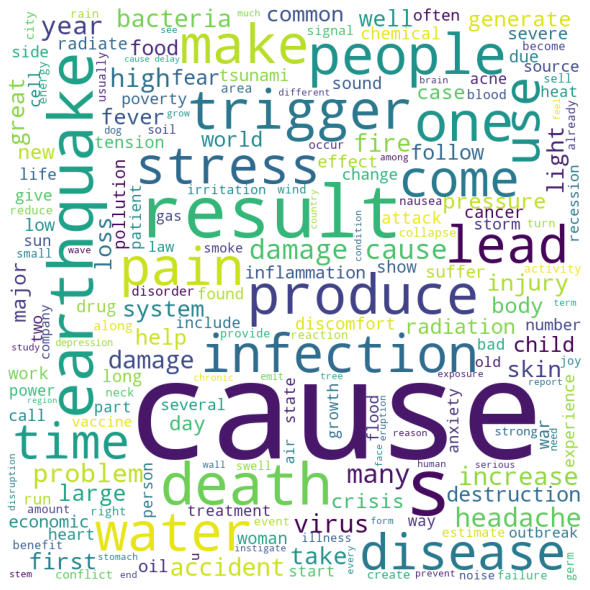

In [226]:
#adam_word cloud code reference from https://www.geeksforgeeks.org/generating-word-cloud-python/
#adam_nltk stopwords & tokenize from https://www.geeksforgeeks.org/removing-stop-words-nltk-python
#adam_nltk lammatization & POS tag from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ''

# iterate through the csv file
for val in df_train_ce_text:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "
#print(comment_words)

import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Stopwords
stop_words = set(stopwords.words('english'))
#Tokenization
word_tokens = word_tokenize(comment_words)
#f stand for filtered
f_comment_words= [w for w in word_tokens if not w.lower() in stop_words]
f_comment_words=[]

for w in word_tokens:
	if w not in stop_words:
		f_comment_words.append(w)
#print(word_tokens)
#print(f_comment_words)
#print(type(f_comment_words))

#Lemmatization with POS tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

wl = WordNetLemmatizer()

lemmatized_words = ' '.join([wl.lemmatize(w, get_wordnet_pos(w)) for w in f_comment_words])

#wordcloud
wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				min_font_size = 10).generate(lemmatized_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

####Word Cloud for Test data

In [227]:
#adam_filter out all other clasification except Cause-Effect 
df_test_ce=df_test[(df_test.Clasification == 'Cause-Effect')]
df_test_ce.head(10)

,ID,Text,Clasification,Clasification_ID
8,8005,Avian influenza is an infectious disease of bi...,Cause-Effect,1
52,8027,The same effect is achieved the traditional wa...,Cause-Effect,1
60,8031,Of the hundreds of strains of avian influenza ...,Cause-Effect,1
80,8041,The subject of imply is the source of an impli...,Cause-Effect,1
84,8043,The treaty establishes a double majority rule ...,Cause-Effect,1
108,8055,"In South Africa, which has one of the best pol...",Cause-Effect,1
114,8058,Traffic vibrations on the street outside had c...,Cause-Effect,1
144,8073,"The slide, which was triggered by an avalanche...",Cause-Effect,1
164,8083,Muscle fatigue is the number one cause of arm ...,Cause-Effect,1
208,8105,It spilled more than 53000 gallons of crude oi...,Cause-Effect,1


In [228]:
#adam_Select only Text column
df_test_ce_text=df_test_ce["Text"]

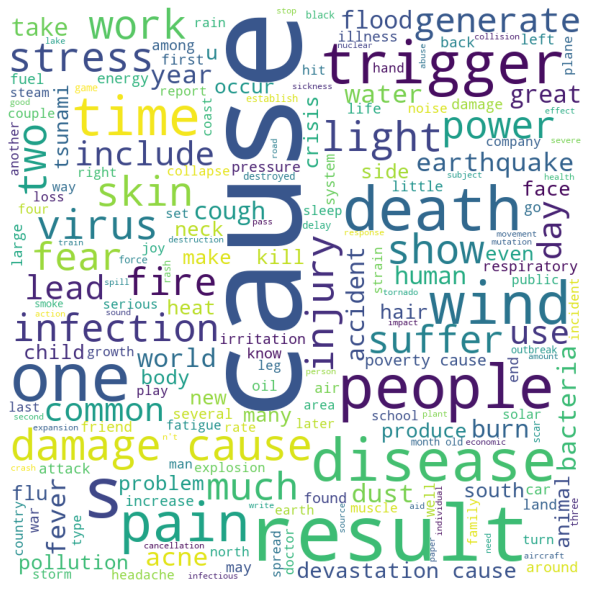

In [229]:
test_comment_words = ''

# iterate through the csv file
for val in df_test_ce_text:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	test_comment_words += " ".join(tokens)+" "
#print(test_comment_words)

test_word_tokens = word_tokenize(test_comment_words)
#f stand for filtered
test_f_comment_words= [w for w in word_tokens if not w.lower() in stop_words]
test_f_comment_words=[]

for w in test_word_tokens:
	if w not in stop_words:
		test_f_comment_words.append(w)
#print(test_word_tokens)
#print(test_f_comment_words)
#print(type(test_f_comment_words))


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

test_lemmatized_words = ' '.join([wl.lemmatize(w, get_wordnet_pos(w)) for w in test_f_comment_words])

#wordcloud
wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				min_font_size = 10).generate(test_lemmatized_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Data Frequency

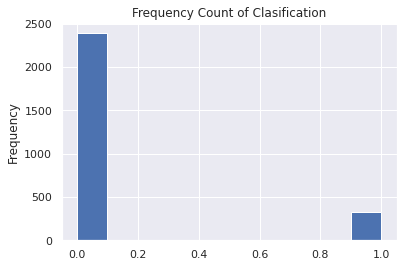

In [230]:
df_test.Clasification_ID.plot.hist(bins=10, title='Frequency Count of Clasification')

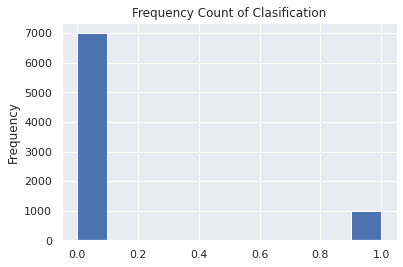

In [231]:
df_train.Clasification_ID.plot.hist(bins=10, title='Frequency Count of Clasification')

## Step 3: Data Preprocessing

In [232]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)  

def finalpreprocess(string):
    return lemmatizer(stopword(string))


In [233]:
df_train['Text'] = df_train['Text'].apply(lambda x: finalpreprocess(x))
df_test['Text'] = df_test['Text'].apply(lambda x: finalpreprocess(x))

### Oversample for Imbalanced Data

In [234]:
import imblearn
from imblearn.over_sampling  import RandomOverSampler
from imblearn.pipeline import make_pipeline

In [235]:
# fit and apply the transform
tv = TfidfVectorizer(ngram_range=(1,3)) 
ros = RandomOverSampler(sampling_strategy='minority')
train_data, train_target = ros.fit_resample(tv.fit_transform(train_data), train_target)
test_data = tv.transform(test_data)

## Step 4: Training Models


### Train model 1: Multinomial Naive Bayes (standard parameters)

In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers. For this we will use the TF-IDF vectorizer and create a pipeline that attaches it to a multinomial naive Bayes classifier

**MultinomialNB()** 

Tutorial on Multinomial Naive Bayes classification: https://youtu.be/O2L2Uv9pdDA

In Depth: Naive Bayes Classification by Jake VanderPlas 2016 https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html 

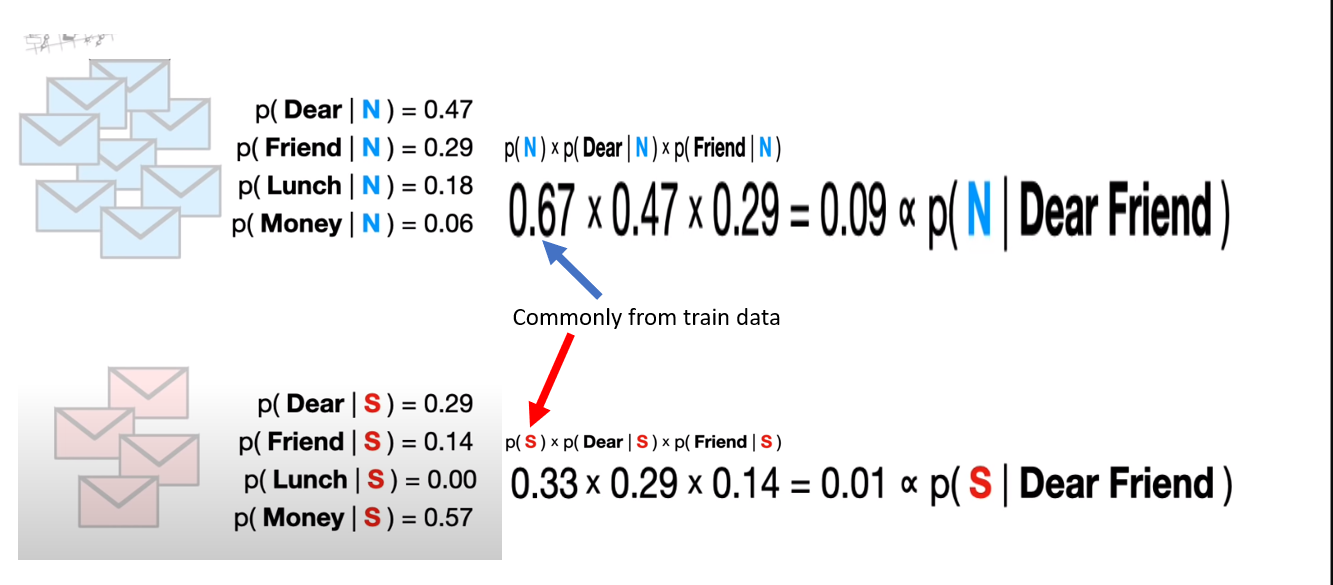

Resources to learn more about TF-IDF Vectoriser and SKLearn Features

**TfidfVectorizer()**: https://monkeylearn.com/blog/what-is-tf-idf/

**sklearn.feature_extraction.text & Tfidverctorizer**: https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.
The **term frequency** of a word in a document.
The **inverse document frequency** of the word across a set of documents.
		 the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1.
		Multiplying these two numbers results in the TF-IDF score of a word in a document. 
	The **higher the score, the more relevant that word is** in that particular document. [(Bruno Stecanella, 2019)](https://monkeylearn.com/blog/what-is-tf-idf/)


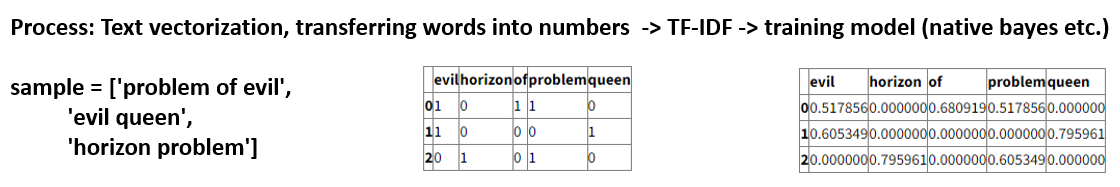

In [236]:
# use the TF-IDF vectorizer and create a pipeline that attaches it to a multinomial naive Bayes classifier
from sklearn.feature_extraction.text import TfidfVectorizer    #Convert a collection of raw documents to a matrix of TF-IDF features
from sklearn.naive_bayes import MultinomialNB                  #multinomial Naive Bayes classifier is suitable for classification with discrete features
from sklearn.pipeline import make_pipeline                     #Construct a Pipeline from the given estimators

#show data
import seaborn as sns; sns.set()                               #data visualization library based on matplotlib
import matplotlib.pyplot as plt                                #interactive plots 
from sklearn.metrics import confusion_matrix                   #Compute confusion matrix to evaluate the accuracy of a classification

In [237]:
#construct a pipeline from the given estimators 
#TfidfVectorizer(), to convert the content of each string into a vector of numbers
#MultinomialNB(), attaches TF-IDF vectorizer to a multinomial naive Bayes clssifier
model = make_pipeline( MultinomialNB())

In [238]:
#With this pipeline, we can apply the model to the training data, and predict labels for the test data (below two code)
model.fit(train_data, train_target)
#fit all the transformers one after the other and transform the data. finally, fit the transformed data using the final estimator. 
labels = model.predict(test_data)
#Call transform of each transformer in the pipeline. the transformed data are finally passed to the final estimator that calls predict method. 
#only valid if the final estimator implements predict.

####Accuracy Rate

In [239]:
accuracy_for_test_keys = np.mean(labels == test_target)
print("Multinomial Naive Bayes Model Accuracy = {} %".format(accuracy_for_test_keys*100))

Multinomial Naive Bayes Model Accuracy = 88.55355171144645 %


####F1-Score

In [240]:
from sklearn import metrics
print(metrics.classification_report(test_target, labels, target_names=keys))
#Precision is the fraction of positive class predictions that actually belong to the positive class. 
#Recall is the fraction of positive class predictions made out of all positive examples in the dataset. 
#F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. 
#Higher F1 scores are generally better.

              precision    recall  f1-score   support

       Other       0.98      0.89      0.93      2389
Cause-Effect       0.52      0.87      0.65       328

    accuracy                           0.89      2717
   macro avg       0.75      0.88      0.79      2717
weighted avg       0.92      0.89      0.90      2717



####Confusion Matrix:
Tutorial: https://youtu.be/Kdsp6soqA7o

<Figure size 8000x8000 with 0 Axes>

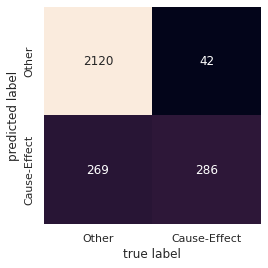

<Figure size 8000x8000 with 0 Axes>

In [241]:
#evaluate the performance of the estimator with confusion matrix between the true and predicted labels for the test data
plt.rcParams['font.size'] = '12'
mat = confusion_matrix(test_target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=keys, yticklabels=keys)

plt.xlabel('true label')
plt.ylabel('predicted label')

from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi=800)

### Train model 2: Multinomial Naive Bayes (optimized parameters)

In this model, we will be working on the same Multinomial Naive Bayes but with optimsed parameters. 

The main difference is the use of
1. Count vectoriser and TF_IDF Transformer rather than TF-IDF Vectoriser
2. Pipeline instead of Make_pipeline

Tutorials:

1. [Naive Bayes Optimisation Parameters](https://holypython.com/nbc/naive-bayes-classifier-optimization-parameters/)
2. [Count Vectoriser to Extract Features from Text](https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/)
3. [TfidfVectorizer vs TfidfTransformer](https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275)
4. [TfidVectorizer and TfidTransformer Usage Differences](https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.YwzPLNNBzb1)
5. [Pipeline vs Make_pipeline](https://www.geeksforgeeks.org/what-is-the-difference-between-pipeline-and-make_pipeline-in-scikit/)


In [242]:
from sklearn.pipeline import Pipeline



In [243]:
pipeline = Pipeline([
    ('clf', MultinomialNB()),
])
parameters = {
    'clf__alpha': [0.1,5,10,50,100],
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(train_data, train_target)
y_predicted = grid_search.predict(test_data)
#pipeline It is used to execute the process sequentially and execute the steps, transformers, or estimators are named manually. Transformers and estimators are the parameters to fit the model and tune for its model accuracy.
#make_pipeline is an advanced method in scikit learn, in which the naming of the estimators or transformers are done automatically.

# Naive Bayes predicted values is saving to csv file
# np.savetxt("naive_bayes_predicted.csv", predicted, delimiter=",")


####Accuracy Rate

In [244]:
accuracy_for_test_keys = np.mean(y_predicted == test_target)
print("Multinomial Naive Bayes Model Accuracy = {} %".format(accuracy_for_test_keys*100))

Multinomial Naive Bayes Model Accuracy = 92.3813029076187 %


####F1-Score

In [245]:
from sklearn import metrics
print(metrics.classification_report(test_target, y_predicted, target_names=keys))
#Precision is the fraction of positive class predictions that actually belong to the positive class. 
#Recall is the fraction of positive class predictions made out of all positive examples in the dataset. 
#F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. 
#Higher F1 scores are generally better.

              precision    recall  f1-score   support

       Other       0.97      0.94      0.96      2389
Cause-Effect       0.65      0.79      0.72       328

    accuracy                           0.92      2717
   macro avg       0.81      0.87      0.84      2717
weighted avg       0.93      0.92      0.93      2717



####Confusion Matrix

<Figure size 8000x8000 with 0 Axes>

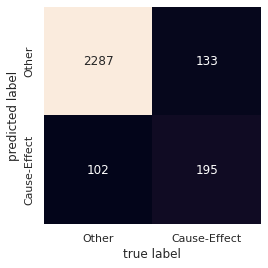

<Figure size 8000x8000 with 0 Axes>

In [246]:
plt.rcParams['font.size'] = '12'
mat = confusion_matrix(test_target, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=keys, yticklabels=keys)

plt.xlabel('true label')
plt.ylabel('predicted label')

from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi=800)

### Train model 3: Support Vector Machine BASIC

####Support Vector Model

The core idea of SVM is to find a maximum marginal hyperplane(MMH) that best divides the dataset into classes.

<img src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526288453/index3_souoaz.png" width=300px>

[Source: DataCamp](https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python)








In [247]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
#Reference: https://gist.github.com/dspp779/5a9597e2d8a2518b80fb0ad191ea8463

In [248]:
#Build a vectorizer / classifier pipeline that filters out tokens that are too rare or too frequent
text_clf = Pipeline([ ('clf', SVC()),
])

In [249]:
text_clf.fit(train_data, train_target)

Pipeline(steps=[('clf', SVC())])

In [250]:
y_predicted = text_clf.predict(test_data)

####Accuracy Rate

In [251]:
accuracy_for_test_keys = np.mean(y_predicted == test_target)
print("SVM Model Accuracy = {} %".format(accuracy_for_test_keys*100))

SVM Model Accuracy = 95.32572690467427 %


####F1-Score

In [252]:
from sklearn import metrics
print(metrics.classification_report(test_target, y_predicted, target_names=keys))
#Precision is the fraction of positive class predictions that actually belong to the positive class. 
#Recall is the fraction of positive class predictions made out of all positive examples in the dataset. 
#F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. 
#Higher F1 scores are generally better.

              precision    recall  f1-score   support

       Other       0.96      0.99      0.97      2389
Cause-Effect       0.92      0.67      0.78       328

    accuracy                           0.95      2717
   macro avg       0.94      0.83      0.87      2717
weighted avg       0.95      0.95      0.95      2717



####Confusion Matrix

<Figure size 7200x7200 with 0 Axes>

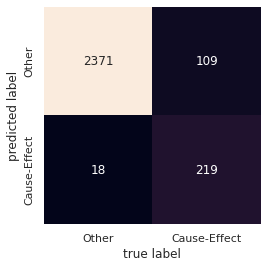

<Figure size 7200x7200 with 0 Axes>

In [253]:
#evaluate the performance of the estimator with confusion matrix between the true and predicted labels for the test data
plt.rcParams['font.size'] = '12'
mat = confusion_matrix(test_target, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=keys, yticklabels=keys)

plt.xlabel('true label')
plt.ylabel('predicted label')

from matplotlib.pyplot import figure
figure(figsize=(9, 9), dpi=800)

### Train model 4: Support Vector Machine Linear Kernel

####Kernels
Some problems can’t be solved using linear hyperplane. In such situation, SVM uses a kernel trick to transform the input space to a higher dimensional space. Eg. RBF kernel (left picture) creates non-linear combinations of your features where you can use a linear decision boundary to separate your classes. Some other kernls can be found in the right picture.

<img src="https://sebastianraschka.com/images/faq/select_svm_kernels/5.png" width=300px> 
<img src="https://miro.medium.com/max/1400/1*qZFPN60NvwbFE_tRg2YPoQ.png" width=300px>

Source: [Sebastian Raschka, 2022](https://sebastianraschka.com/faq/docs/select_svm_kernels.html)

**Choosing Kernels**

We can use cycle through several kernels to evaluate which will be most accurate for our data. 
[Nachiketa Hebbar, May 2020](https://www.youtube.com/watch?v=b4qQzVPWkZQ)

As we are dealing with text classification, which is quite widely studied and can be linearly separated, and the linear kernel is mostly preferred for text-classification problems. [Saumya Awasthi, 2020](https://dataaspirant.com/svm-kernels/#t-1608054630727)

In [254]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
#Reference: https://gist.github.com/dspp779/5a9597e2d8a2518b80fb0ad191ea8463

In [255]:
#Build a vectorizer / classifier pipeline that filters out tokens that are too rare or too frequent
text_clf = Pipeline([  ('clf', LinearSVC()),
])

In [256]:
text_clf.fit(train_data, train_target)

Pipeline(steps=[('clf', LinearSVC())])

In [257]:
y_predicted = text_clf.predict(test_data)

####Accuracy Rate

In [258]:
accuracy_for_test_keys = np.mean(y_predicted == test_target)
print("SVM Model Accuracy = {} %".format(accuracy_for_test_keys*100))

SVM Model Accuracy = 96.20905410379095 %


####F1-Score

In [259]:
from sklearn import metrics
print(metrics.classification_report(test_target, y_predicted, target_names=keys))
#Precision is the fraction of positive class predictions that actually belong to the positive class. 
#Recall is the fraction of positive class predictions made out of all positive examples in the dataset. 
#F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. 
#Higher F1 scores are generally better.

              precision    recall  f1-score   support

       Other       0.97      0.98      0.98      2389
Cause-Effect       0.88      0.80      0.84       328

    accuracy                           0.96      2717
   macro avg       0.93      0.89      0.91      2717
weighted avg       0.96      0.96      0.96      2717



####Confusion Matrix

<Figure size 7200x7200 with 0 Axes>

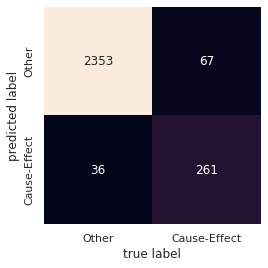

<Figure size 7200x7200 with 0 Axes>

In [260]:
#evaluate the performance of the estimator with confusion matrix between the true and predicted labels for the test data
plt.rcParams['font.size'] = '12'
mat = confusion_matrix(test_target, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=keys, yticklabels=keys)

plt.xlabel('true label')
plt.ylabel('predicted label')

from matplotlib.pyplot import figure
figure(figsize=(9, 9), dpi=800)

### Train model 5: Support Vector Machine Linear Kernel with Gridsearch (2/3-gram)

####GridsearchCV

Grid-search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.

[Rohan Joseph, 2018](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)

In [261]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
#Reference: https://gist.github.com/dspp779/5a9597e2d8a2518b80fb0ad191ea8463

In [262]:
#Build a vectorizer / classifier pipeline that filters out tokens that are too rare or too frequent
pipeline = Pipeline([
    ('clf', LinearSVC()),
])

In [263]:
#Build a grid search to find out whether 2-grams or 3-grams are more useful. 
#Fit the pipeline on the training set using grid search for the parameters
parameters = {
    'clf__C': [0.1,1,10,100,1000],
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(train_data, train_target)

GridSearchCV(estimator=Pipeline(steps=[('clf', LinearSVC())]), n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100, 1000]})

In [264]:
#Print the mean and std for each candidate along with the parameter settings for all the candidates explored by grid search.
n_candidates = len(grid_search.cv_results_['params'])
for i in range(n_candidates):
    print(i, 'params - %s; mean - %0.2f; std - %0.2f'
             % (grid_search.cv_results_['params'][i],
                grid_search.cv_results_['mean_test_score'][i],
                grid_search.cv_results_['std_test_score'][i]))

0 params - {'clf__C': 0.1}; mean - 0.99; std - 0.00
1 params - {'clf__C': 1}; mean - 1.00; std - 0.00
2 params - {'clf__C': 10}; mean - 1.00; std - 0.00
3 params - {'clf__C': 100}; mean - 1.00; std - 0.00
4 params - {'clf__C': 1000}; mean - 1.00; std - 0.00


In [265]:
#Predict the outcome on the testing set and store it in a variable named y_predicted
y_predicted = grid_search.predict(test_data)

####Accuracy Rate

In [266]:
accuracy_for_test_keys = np.mean(y_predicted == test_target)
print("SVM Model Accuracy = {} %".format(accuracy_for_test_keys*100))

SVM Model Accuracy = 96.20905410379095 %


####F1-Score

In [267]:
from sklearn import metrics
print(metrics.classification_report(test_target, y_predicted, target_names=keys))
#Precision is the fraction of positive class predictions that actually belong to the positive class. 
#Recall is the fraction of positive class predictions made out of all positive examples in the dataset. 
#F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. 
#Higher F1 scores are generally better.

              precision    recall  f1-score   support

       Other       0.97      0.98      0.98      2389
Cause-Effect       0.88      0.80      0.84       328

    accuracy                           0.96      2717
   macro avg       0.93      0.89      0.91      2717
weighted avg       0.96      0.96      0.96      2717



####Confusion Matrix

<Figure size 7200x7200 with 0 Axes>

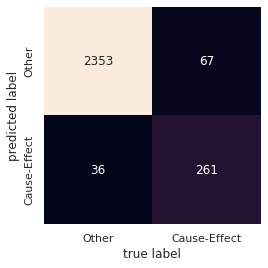

<Figure size 7200x7200 with 0 Axes>

In [268]:
#evaluate the performance of the estimator with confusion matrix between the true and predicted labels for the test data
plt.rcParams['font.size'] = '12'
mat = confusion_matrix(test_target, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=keys, yticklabels=keys)

plt.xlabel('true label')
plt.ylabel('predicted label')

from matplotlib.pyplot import figure
figure(figsize=(9, 9), dpi=800)

In [269]:
df_test['Predicted'] = y_predicted
#BEATRICE Return Predicted Cause-Effect Statements 
df_ceff=df_test[(df_test.Predicted.eq(1))]
df_ceff.head(10)


,ID,Text,Clasification,Clasification_ID,Predicted
8,8005,Avian influenza infectious disease bird cause ...,Cause-Effect,1,1
60,8031,"Of hundred strain avian influenza A virus , fo...",Cause-Effect,1,1
66,8034,"Essentially , blister appear mouth cause herpe...",Other,0,1
78,8040,Roundworms ascarids cause intestinal parasite ...,Other,0,1
114,8058,Traffic vibration street outside caused moveme...,Cause-Effect,1,1
144,8073,"The slide , trigger avalanche-control crew , d...",Cause-Effect,1,1
164,8083,Muscle fatigue number one cause arm muscle pain .,Cause-Effect,1,1
208,8105,It spill 53000 gallon crude oil surround marsh...,Cause-Effect,1,1
212,8107,The disease cause gene mutation X chromosome .,Cause-Effect,1,1
214,8108,"The pretext offer laughable , response cause s...",Cause-Effect,1,1


##References

#####SemEval 2010 Task
1. SemEval 2010 Task 8 - Analytic Munch, Varun Kashyap.K.S., 2016 http://analyticmunch.weebly.com/semeval-2010-task-8.html

#####NLTK
2. Removing stop words with NLTK in Python, Pratima Upadhyay, 2022 https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

#####Naive Bayes
3. Naive Bayes, Clearly Explained!!!, Josh Stamer, 2020 https://youtu.be/O2L2Uv9pdDA
4. In Depth: Naive Bayes Classification, Jake VanderPlas, 2016 https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html
5. Understanding TF-ID: A Simple Introduction, Bruno Stecanella, 2019  https://monkeylearn.com/blog/what-is-tf-idf/
6. Feature Engineering, Jake VanderPlas, 2016 https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html
7. Naive Bayes Optimization, HolyPython, 2021 https://holypython.com/nbc/naive-bayes-classifier-optimization-parameters/

#####Count Vectoriser, TF-IDF and Pipelines
8. Count Vectoriser to Extract Features, Khushali Verma, 2022 https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/
9. TF-IDF Explained And Python Sklearn Implementation, Marius Borcan, 2020 https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275
10. How to Use Tfidftransformer & Tfidfvectorizer?, Kavita Ganesan, 2022 https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.YxBZJXbP2Um
11. What is the difference between pipeline and make_pipeline in scikit? 
Sujithra Baskaran, 2022 https://www.geeksforgeeks.org/what-is-the-difference-between-pipeline-and-make_pipeline-in-scikit/

#####Confusion Matrix, Precision, Recall & F1
12. Machine Learning Fundamentals: The Confusion Matrix, Josh Stammer, 2018 https://www.youtube.com/watch?v=Kdsp6soqA7o
13. Accuracy, Precision, Recall or F1? Koo Ping Shung, 2018 https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

#####Support Vector Model
14. Text classification with SVM example, GitHub UserID: dspp779, 2017 https://gist.github.com/dspp779/5a9597e2d8a2518b80fb0ad191ea8463
15. Support Vector Machines with Scikit-learn Tutorial, DataCamp https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

#####SVM Kernels and Grid Search
16. How do I select SVM kernels? Sebastian Raschka, 2022 https://sebastianraschka.com/faq/docs/select_svm_kernels.html
17. Training SVM model in Python| Hyper-parameter Tuning|GridSearch CV |Support Vector Machines #3| Nachiketa Hebbar, 2020 https://www.youtube.com/watch?v=b4qQzVPWkZQ
18. Seven Most Popular Kernels, Saumya Awasthi, 2020 https://dataaspirant.com/svm-kernels/#t-1608054630727
19. Grid Search for model tuning, Rohan Joseph, 2018
https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e

##